In [4]:
import numpy as np
import sys
sys.path.append("/cluster/users/tom/git/neon_blink_detection/")

from training.video_loader import video_loader
from src.helper import OfParams
from pathlib import Path

video_path = Path("/cluster/users/tom/experiments/neon_blink_detection/datasets/train_data")
of_path = Path("/cluster/users/tom/experiments/neon_blink_detection/datasets/train_data/optical_flow")

of_params = OfParams()

clip_names = np.array(
    [

        "2023-02-01_11-45-11-7621531e",
        "1002-2022-12-14-11-43-58-23e05b8c",
    ]
)


In [5]:
rec = video_loader(of_params)
from utils import resize_images, rotate_images


In [6]:
ts, images_left, images_right = rec._get_frames(clip_names[0], convert_to_gray=True)
blink_df = rec._load_gt_labels(clip_names[0])


In [7]:
x = np.linspace(0, 64, 65)

x = np.linspace(0, 63, 64, dtype=np.float32)
y = np.linspace(0, 63, 64, dtype=np.float32)
xx, yy = np.meshgrid(x, y) 
p_grid = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

(2604, 192, 192, 1)

In [248]:
import scipy
from scipy.ndimage import rotate

blink_ts = blink_df[blink_df["label"]=="onset"].iloc[6, :]["start_ts"]
blink_on_idx = int(np.where(ts == blink_ts)[0])
blink_ts = blink_df[blink_df["label"]=="offset"].iloc[5, :]["end_ts"]
blink_off_idx = int(np.where(ts == blink_ts)[0])

of_params.grid_size = 15
of_params.n_layers = 7
of_params.layer_interval = 5
of_params.window_size = 15

print(blink_on_idx)
print(blink_off_idx)

images = images_left[blink_on_idx-30:blink_off_idx+30, :, :]
images_left_rot = np.zeros(images_left.shape)

for ifr in range(0, images_left.shape[0]):
    images_left_rot[ifr, :, :] = rotate(images_left[ifr, :, :], 30, reshape=False, mode="nearest")

images_rot = images_left_rot[blink_on_idx-30:blink_off_idx+30, :, :]

feature_array, grid = rec._compute_optical_flow(of_params, images_left, images_right)
feature_array_rot, grid = rec._compute_optical_flow(of_params, images_left_rot, images_right)

feature_array = feature_array[blink_on_idx-30:blink_off_idx+30, :, :]
feature_array_rot = feature_array_rot[blink_on_idx-30:blink_off_idx+30, :, :]

zz = np.zeros([64, 64, feature_array.shape[0]])
zz_rot = np.zeros([64, 64, feature_array.shape[0]])
frame_counter = 0

zz = scipy.interpolate.griddata(grid, feature_array[:, 0:225, 1].transpose(), p_grid, method="linear")

zz = zz.reshape(64, 64, zz.shape[1])

zz_rot = scipy.interpolate.griddata(grid, feature_array_rot[:, 0:225, 1].transpose(), p_grid, method="linear")

zz_rot = zz_rot.reshape(64, 64, zz_rot.shape[1])

# for iframe in range(0, feature_array.shape[0]):
#     a=scipy.interpolate.griddata(grid, feature_array[iframe, 0:225, 1], p_grid, method="linear")
#     b=scipy.interpolate.griddata(grid, feature_array_rot[iframe, 0:225, 1], p_grid, method="linear")
#     count = 0
#     for ix in range(0, 64):
#         for iy in range(0, 64):
#             zz[ix, iy, frame_counter] = a[count]
#             zz_rot[ix, iy, frame_counter] = b[count]
#             count += 1
    
#     frame_counter += 1



1183
1235


In [100]:
img = np.zeros([64, 64, 5])
for i in range(0, 5):
    a=scipy.interpolate.griddata(grid, feature_array[100+i, 0:225, 1], p_grid, method="linear")
    img[:, :, i] = a.reshape(64,64)

In [192]:
import typing as T

def zoom_center(img, zoom_factor: int, shift: T.List[int]):

    y_size = img.shape[0]
    x_size = img.shape[1]
    
    img = scipy.ndimage.shift(img, [shift[0], shift[1], 0], mode="nearest")

    # define new boundaries
    x1 = int(0.5*x_size*(1-1/zoom_factor)) 
    x2 = int(x_size-0.5*x_size*(1-1/zoom_factor))
    y1 = int(0.5*y_size*(1-1/zoom_factor))
    y2 = int(y_size-0.5*y_size*(1-1/zoom_factor))

    # first crop image then scale
    img_cropped = img[y1:y2,x1:x2, :]

    
    return cv2.resize(img_cropped, None, fx=zoom_factor, fy=zoom_factor)


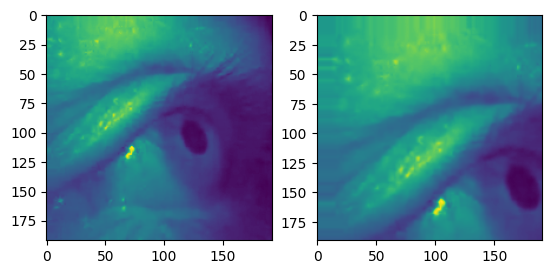

In [202]:

i = 10
img_zoom = zoom_center(images_left[i, :, :, :], zoom_factor=1.3, shift=[30, 30])

f, ax = plt.subplots(1,2)
ax[0].imshow(images_left[i, :, :, 0])
ax[1].imshow(img_zoom)


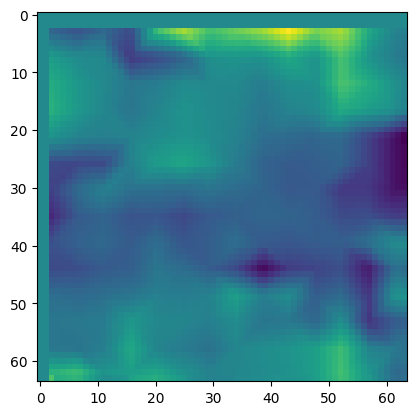

In [167]:
plt.imshow()

In [249]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# np array with shape (frames, height, width, channels)
video = images

fig, axs = plt.subplots(2,2)
im0 = axs[0, 0].imshow(video[0,:,:,:], cmap='gray')
axs[0, 0].axis("off")

im1 = axs[0, 1].imshow(zz[:,:,0], vmin=-10, vmax=10)
axs[0, 1].axis("off")

video1 = images_rot

im2 = axs[1, 0].imshow(video1[0,:,:,:], cmap='gray')
axs[1, 0].axis("off")

im3 = axs[1, 1].imshow(zz_rot[:,:,0], vmin=-10, vmax=10)
axs[1, 1].axis("off")

plt.close() # this is required to not display the generated image

def init():
    im0.set_data(video[0,:,:,:])
    im1.set_data(zz[:,:,0])
    im2.set_data(video1[0,:,:,:])
    im3.set_data(zz_rot[:,:,0])

def animate(i):
    im0.set_data(video[i,:,:,:])
    im1.set_data(zz[:,:,i])
    im2.set_data(video1[i,:,:,:])
    im3.set_data(zz_rot[:,:,i])
    return im0, im1, im2, im3

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=50)
HTML(anim.to_html5_video())

In [111]:

def _shift_image(img, y_shift = 0, x_shift = 0):
    """ Shift image by y_shift (positive: up, negative: down) and x_shift (positive: right, negative: left) pixels. 
    img: HxWxNxM array (where N and M are optional dimensions)
    """

    if np.sign(x_shift) == 1:
        x_left = 0
        x_right = x_shift
    else:
        x_left = -x_shift
        x_right = 0

    if np.sign(y_shift) == 1:
        y_up = y_shift
        y_down = 0
    else:
        y_up = 0
        y_down = -y_shift

    if img.ndim == 2:
        return np.pad(img, ((y_down, y_up), (x_right, x_left)), mode="linear_ramp")[y_up:y_up+img.shape[0], x_left:img.shape[0]+x_left]
    
    elif img.ndim == 3:
        return np.pad(img, ((y_down, y_up), (x_right, x_left), (0, 0)), mode="linear_ramp")[y_up:y_up+img.shape[0], x_left:img.shape[0]+x_left, :]

    elif img.ndim == 4:
        return np.pad(img, ((y_down, y_up), (x_right, x_left), (0, 0), (0, 0)), mode="linear_ramp")[y_up:y_up+img.shape[0], x_left:img.shape[0]+x_left, :, :]

    else: 
        raise ValueError("Image must be 2D, 3D or 4D array")




In [207]:
import typing as T
def _zoom_and_shift(
    self, img: np.ndarray, zoom_factor: np.float32, shift: T.List[int]
):

    size = img.shape

    img = self._shift_image(img, y_shift=shift[0], x_shift=shift[1])

    lim1 = int(0.5 * size[0] * (1 - 1 / zoom_factor))
    lim2 = int(size[0] - 0.5 * size[0] * (1 - 1 / zoom_factor))

    img_cropped = img[lim1:lim2, lim1:lim2, :, :]

    img_cropped = img_cropped.reshape(
        img_cropped.shape[0],
        img_cropped.shape[1],
        size[2] * size[3],
    )

    # Split in chunks as cv2 cannot seem to handle large images
    split_idc = list(range(500, img_cropped.shape[-1], 500))
    split_img = np.split(img_cropped, split_idc, axis=2)

    img_list = [
        cv2.resize(img, None, fx=zoom_factor, fy=zoom_factor) for img in split_img
    ]

    img_resized = np.concatenate(img_list, axis=2)
    img_resized = img_resized.reshape(size)

    return img_resized

In [3]:
blink_ts = blink_df[blink_df["label"]=="onset"].iloc[6, :]["start_ts"]
blink_on_idx = int(np.where(ts == blink_ts)[0])
blink_ts = blink_df[blink_df["label"]=="offset"].iloc[5, :]["end_ts"]
blink_off_idx = int(np.where(ts == blink_ts)[0])

of_params.grid_size = 15
of_params.n_layers = 7
of_params.layer_interval = 5
of_params.window_size = 15

print(blink_on_idx)
print(blink_off_idx)

images = images_left[blink_on_idx-30:blink_off_idx+30, :, :]

feature_array, grid = rec._compute_optical_flow(of_params, images_left, images_right)
# feature_array = feature_array[blink_on_idx-30:blink_off_idx+30, :, :]

def sine_wave(t, frequency, sampling_rate):
    y = np.sin(2*np.pi*frequency*t)
    return y


fs = 200
dur = feature_array.shape[0]/fs


NameError: name 'blink_df' is not defined

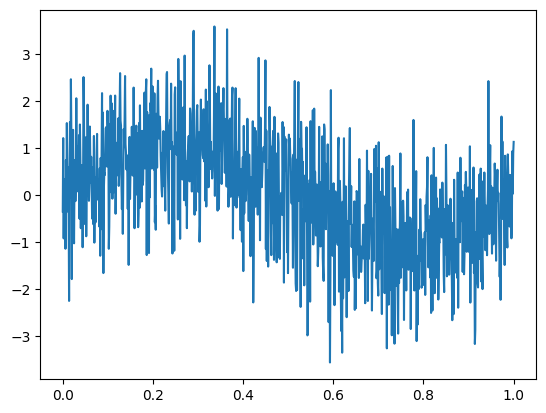

In [76]:
def sine_wave_plus_noise(t, frequency, sampling_rate, noise_level):
    y = np.sin(2*np.pi*frequency*t) + noise_level*np.random.randn(t.shape[0])
    return y

t = np.linspace(0, 1, 1000)
y = sine_wave_plus_noise(t, 1, 1000, 1)

plt.plot(t, y)

In [89]:
from scipy.interpolate import griddata
t = np.linspace(0, dur, feature_array.shape[0])
y = sine_wave_plus_noise(t, 100, 1000, 1)
sine_feature_array  = feature_array+np.tile(y*5, (2,450,1)).transpose((2,1,0))*np.random.randn(feature_array.shape[0], 450, 2)*0.3 + np.tile(y*2, (2,450,1)).transpose((2,1,0))

zz = griddata(grid, sine_feature_array[:, 0:225, 1].transpose(), p_grid, method="linear")

zz = zz.reshape(64, 64, zz.shape[1])


In [90]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# np array with shape (frames, height, width, channels)
video = images

fig, axs = plt.subplots(2,2)
im0 = axs[0, 0].imshow(video[0,:,:,:], cmap='gray')
axs[0, 0].axis("off")

im1 = axs[0, 1].imshow(zz[:,:,0], vmin=-10, vmax=10)
axs[0, 1].axis("off")

# video1 = images_rot

# im2 = axs[1, 0].imshow(video1[0,:,:,:], cmap='gray')
# axs[1, 0].axis("off")

# im3 = axs[1, 1].imshow(zz_rot[:,:,0], vmin=-10, vmax=10)
# axs[1, 1].axis("off")

plt.close() # this is required to not display the generated image

def init():
    im0.set_data(video[0,:,:,:])
    im1.set_data(zz[:,:,0])
    # im2.set_data(video1[0,:,:,:])
    # im3.set_data(zz_rot[:,:,0])

def animate(i):
    im0.set_data(video[i,:,:,:])
    im1.set_data(zz[:,:,i])
    # im2.set_data(video1[i,:,:,:])
    # im3.set_data(zz_rot[:,:,i])
    return im0, im1#, im2, im3

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=50)
HTML(anim.to_html5_video())

In [12]:
images_left.shape

(46904, 192, 192, 1)

**IMAGE TRANSFORMATION**

(using pytorch)

In [79]:
import scipy
from scipy.ndimage import rotate

blink_ts = blink_df[blink_df["label"]=="onset"].iloc[0, :]["start_ts"]
blink_on_idx = int(np.where(ts == blink_ts)[0])
blink_ts = blink_df[blink_df["label"]=="offset"].iloc[0, :]["end_ts"]
blink_off_idx = int(np.where(ts == blink_ts)[0])

of_params.grid_size = 15
of_params.n_layers = 7
of_params.layer_interval = 5
of_params.window_size = 15

print(blink_on_idx)
print(blink_off_idx)

images = images_left[blink_on_idx-30:blink_off_idx+30, :, :]

feature_array, grid = rec._compute_optical_flow(of_params, images_left[0:3000, :, :, :], images_right[0:3000, :, :, :])

feature_array = feature_array[blink_on_idx-30:blink_off_idx+30, :, :]



81
127


In [80]:
zz = np.tile(zz, (1, 1, 50)).reshape(64, 64, int(5300/2), 2)

In [180]:
x.shape

(64, 64, 7, 1000)

In [583]:
feat_arr_left, feat_arr_right = rec._interpolate_feature_array(rec.all_features[clip_names[0]][0:1000, :])

(64, 64, 7, 1000)

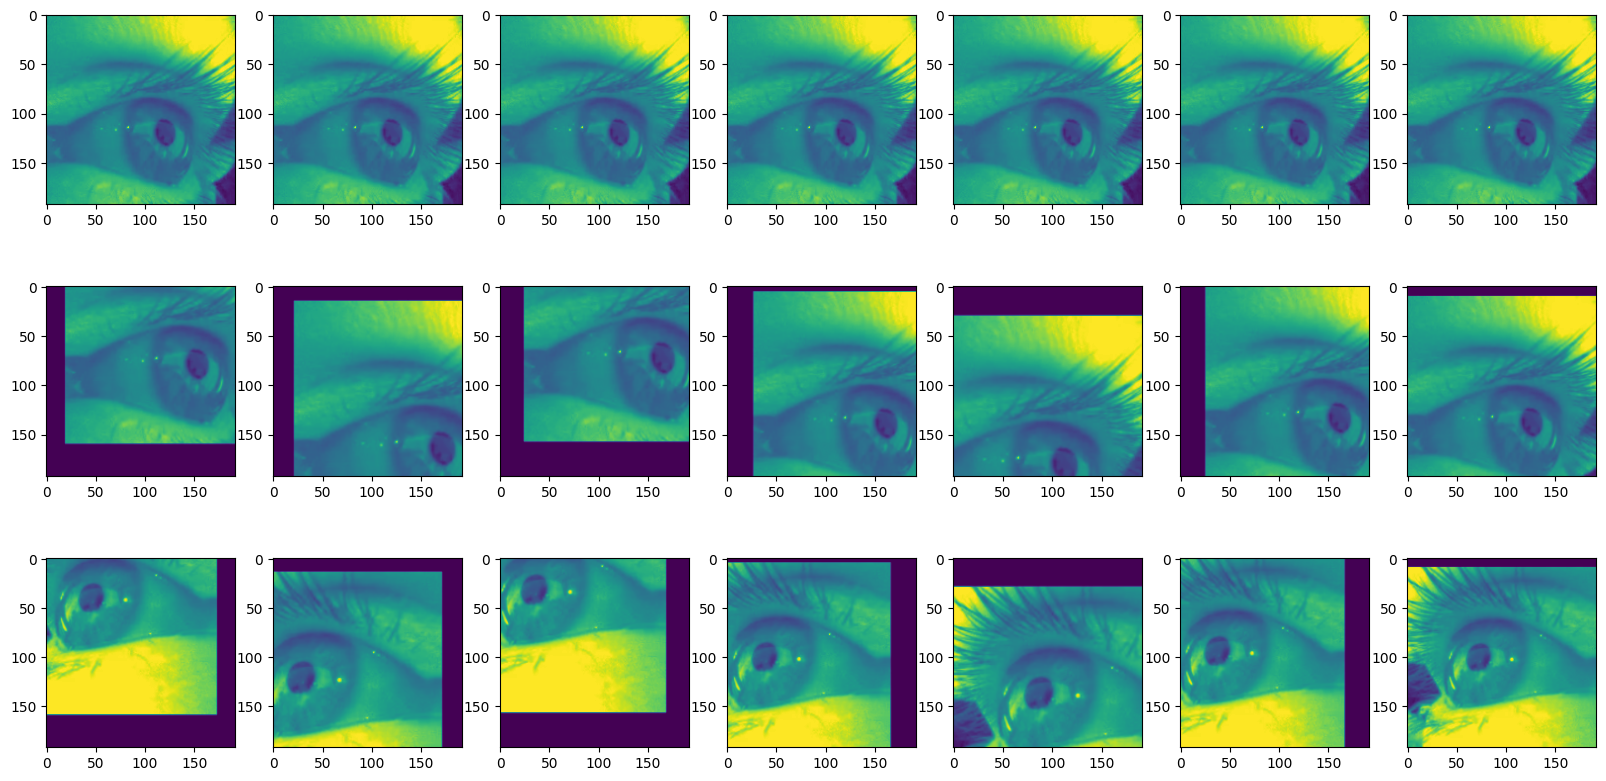

In [1038]:
# del transf

images_l = images_left[blink_on_idx-30:blink_off_idx+30, :, :]
images_r = images_right[blink_on_idx-30:blink_off_idx+30, :, :]

import kornia.augmentation as K
import torch
fal_l = np.tile(images_l.squeeze().astype(np.float32), (50, 1, 1, 1))
fal_r = np.tile(images_r.squeeze().astype(np.float32), (50, 1, 1, 1))
size = feat_arr_left.shape

fal_l = torch.from_numpy(fal_l)
fal_r = torch.from_numpy(fal_r)

transf = K.RandomAffine(0, translate=(0.3, 0.3), scale=(0.8, 1.4), p=1, padding_mode="zeros")

transf_feature_left = transf(fal_l)
transf_feature_left = transf_feature_left.numpy().squeeze()

h_flip = K.RandomHorizontalFlip(p=1)
fal_r = h_flip(fal_r)

transf_feature_right = transf(fal_r, params=transf._params)

transf_feature_right = h_flip(transf_feature_right)
transf_feature_right = transf_feature_right.numpy().squeeze()

f, ax = plt.subplots(3, 7)
f.set_size_inches(20, 10)

[ax[0, x].imshow(images_l[x, :, :], vmin=0, vmax=255) for x in range(7)]
[ax[1, x].imshow(transf_feature_left[x, 3, :, :], vmin=0, vmax=255) for x in range(7)]
[ax[2, x].imshow(transf_feature_right[x, 3, :, :], vmin=0, vmax=255) for x in range(7)]

(106, 192, 192, 1)

In [977]:
fal = np.tile(images.squeeze().astype(np.float32), (50, 1, 1, 1))


In [1026]:
fal.shape



torch.Size([50, 106, 192, 192])

In [73]:
def create_grids(
    img_shape: T.Tuple[int, int], grid_size: int, full_grid: bool
) -> np.ndarray:
    x = np.linspace(0, img_shape[1], grid_size, dtype=np.float32)
    y = np.linspace(0, img_shape[0], grid_size, dtype=np.float32)
    xx, yy = np.meshgrid(x, y)
    p_grid = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

    if not full_grid:
        p_grid = p_grid[np.all((p_grid != 0) & (p_grid != img_shape[0]), axis=1), :]

    return p_grid


In [80]:
create_grids(img_shape=img_shape, grid_size=20, full_grid=True).shape

(400, 2)

In [76]:
img_shape

(64, 64)

In [40]:
grid != 0

array([[False, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [False,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True]])